# SASSIE Shipboard TSG 
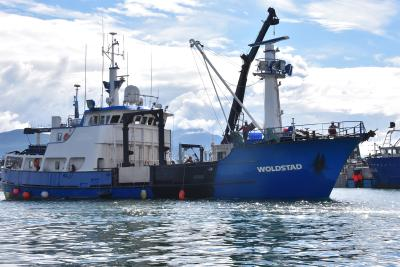
<p>The thermosalinograph on the R/V Woldstad took salinity and temperature measurements at about 4 meters depth throughout the campaign with a temporal resolution of one minute. TSG data are downloaded and plotted using the code below! <b>Please run the 'Data Download and Metadata Viewing' and 'Supporting Code' sections in order before running the 'Figure Making Code'.</b> </p>

<p>The aim of this notebook is to assist the end user in exploratory data analysis by downloading the SASSIE data from NASA's PODAAC, opening the dataset and displaying it's associated metadata, and creating a few visualizations. This notebook was created by Elizabeth Westbrook. For questions and trouble shooting, please email westbrooke@uncw.edu.</p>

# Data Download and Metadata Viewing

The code in this section will download the dataset from PO.DAAC and open it as an xarray object for metadata and variable attribute viewing.

In [ ]:
#IMPORT LIBRARIES#
import numpy as np
import xarray as xr
import glob 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import os
import sys
import pandas as pd
import requests

<h2>Download The TSG data from PO.DAAC</h2>
<p> All data from the SASSIE campaign is stored on NASA's PO.DAAC. The code in this section of the notebook will download SASSIE TSG data from PO.DAAC, which is accessed through earthdata. If you do not already have an earthdata account, you can create one <a href="https://urs.earthdata.nasa.gov/">here</a> . </p>
    <p>Please enter your earthdata credentials below: </p>

In [ ]:
username = 'your_username'
password = 'your_password'
earthdata = requests.auth.HTTPBasicAuth(username, password)

##DIRECTORY TO SAVE TSG DATA
dir_in = 'Data/TSG/'

The next block of code creates the directory specified above and downloads the shipboard TSG file to your binder session if it has not already been downloaded.<b> To download the dataset to your local disk from here, right click on the file you want to download and click 'download'. </b>

In [ ]:
#if the file has not been downloaded, it is downloaded here. 
if not os.path.isfile(dir_in+'SASSIE_Fall_2022_Shipboard_TSG.nc'):
    os.makedirs(dir_in)
    url = 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SASSIE_L2_SHIPBOARD_TSG_V1/SASSIE_Fall_2022_Shipboard_TSG.nc'
    with requests.Session() as session:
            session.auth = (username, password)
            r1 = session.request('get', url)
            r = session.get(r1.url, auth=(username, password))
            if r.status_code == 200:
                if r.ok:
                    with open(dir_in+'SASSIE_Fall_2022_Shipboard_TSG.nc', 'wb') as f:
                        f.write(r.content) 
                        print('Saving Input File: ' + dir_in+'SASSIE_Fall_2022_Shipboard_TSG.nc') 
            else:
                print("Error:", r.status_code)
                if r.status_code == 401:
                    print ('Your Username and/or password are incorrect. Please try again')
else: 
    print('Shipboard TSG file is already in binder directory')

<h2> View The Metadata Inside the TSG File</h2>

The netCDF file has global metadata attributes and attributes associated with each variable. This next block will load data and metadata of the netCDF file into an xarray object (ds). <br> The data set will then be displayed in a clickable HTML format. 

In [ ]:
file = dir_in + '/SASSIE_Fall_2022_Shipboard_TSG.nc'
ds = xr.open_dataset(file)
ds

# Supporting Code 
The code in this section provides a set up for the figure making code below by defining directories for data and figures and creating functions that will be called to actually map the data

<h3>Create a Directory to Save Figures</h3>

In [ ]:
#LOCAL DIRECTORY TO SAVE FIGURES
fig_dir = 'Figures/TSG/'
#FIGURE DIR 
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

<h3>Define a Colormap and Label for Each Variable in the File</h3>

Within this collection of jupyter notebooks, the colormaps used for each variable are held as consistant as possible across all datasets. This function defines the colormap and a label for the variable of interest. 

In [ ]:
#DEFINES COLORMAPS AND LABELS OF EACH VARIABLE IN THIS DATA SET
def define_variable_attributes(var): 
    if var == 'salinity':
        colormap = 'viridis'
        var_label = 'Salinity'
    if var == 'temperature':
        colormap = 'plasma'
        var_label = 'Temperature ($^{\circ}$C)'
    return colormap,var_label

<h3>Are you exploring this entire data set, or just the data collected durring a specific time period?</h3>

<p> In order to efficiently accomplish the data collection goals of the SASSIE campaign, the cruise was broken up into five destinct plays. 
    <br>
    <br>Play 1 - Ice and Open Water Survey
    <br>Play 2 - Zig-Zag Open Water Survey 
    <br>Play 3 - Ice Survey
    <br>Play 4 - Drifter-Following Survey Boxes
    <br>Play 5 - Repeated Ice to Open Water Transect</p>
    <p>The following block of code identifies the start and end datetimes of each of these plays, seperates the dataset into subsets for each play, and puts the start dates, end dates, and subseted data into lists for easier acess later. </p>

In [ ]:
##Identify the start and end times of each play
play1_start = datetime(2022,9,8,8) 
play1_end = datetime(2022,9,13)
play2_start = datetime(2022,9,14)
play2_end = datetime(2022,9,16)
play3_start = datetime(2022,9,16)
play3_end = datetime(2022,9,18)
play4_start = datetime(2022,9,19)
play4_end  = datetime(2022,9,23)
play5_start = datetime(2022,9,25)
play5_end = datetime(2022,9,29)

#subset the dataset into each play. 
play1_data =ds.sel(time=slice(play1_start,play1_end))
play2_data =ds.sel(time=slice(play2_start,play2_end))
play3_data =ds.sel(time=slice(play3_start,play3_end))
play4_data =ds.sel(time=slice(play4_start,play4_end))
play5_data =ds.sel(time=slice(play5_start,play5_end))
campaign_data = ds.sel(time=slice(play1_start,play5_end))

#Create lists of start dates, end dates, and subsetted datasets. 
play_start_dates = [play1_start,play2_start,play3_start,play4_start,play5_start,play1_start]
play_end_dates = [play1_end,play2_end,play3_end,play4_end,play5_end,play5_end]
play_data_all = [play1_data,play2_data,play3_data,play4_data,play5_data,campaign_data]


<h3>Define a Function to Create a Map of the Study Area</h3>

The following function creates a map of the SASSIE study area, which is defined by minimum and maximum lat/lon values. These ranges can be changed later when the function is called to zoom in/out on the study area.

In [ ]:
def map_study_area(latmin = 70, latmax =74,lonmin=-157,lonmax=-140):
    global fig 
    global ax
    
    #create the map as a figure, set the lat and lon ranges, and add land + river data:
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50',zorder=1)
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')
    #Add lat and lon gridlines and labels:
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3) #draw_labels=True gives lat labels.
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,75,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-170,-140,2))
    gl.top_labels = False
    gl.bottom_labels = True 
    gl.right_labels = False
    
    #Add markers for reference cities on the coast:
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK',zorder=2)
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK',zorder=2)
        
    
    

<h3>Configure Supporting Data to Add to Maps</h3>

<p>The functions for viewing and plotting this data set below have options to include bathymetry and/or AMSR ice data to add context to maps. If you are using these options, run
    <br>the following code blocks to:
    <br>1. Create a directory for AMSR ice data and acess bathymetry data from NOAA
    <br>2. Define functions that add these data to your map when called.</p>

<h4>Create Directory for Ice Data and Access Bathymetry Data </h4>

In [ ]:
##LOCAL DIRECTORY TO SAVE AMSR SEA ICE DATA 
ice_dir = 'Ice_Data/'

#ICE DATA DIR
if not os.path.exists(ice_dir):
    os.makedirs(ice_dir)

##READ IN TOPOGRAPHY/BATHYMETRY DATA
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo2.nc'
etopodata = xr.open_dataset(url) 

<h4>Define a Function to Add Ice Data to a Map</h4>
This function will download the AMSR ice product at the start and end date of the time period specified and add it to the plot. 
<br>Ice data from the start date will be shown in blue and ice data from the end date will be shown in red. 

In [ ]:
def add_ice_data(start_date,end_date):
        #get ice data at start of time range
        play_start = start_date
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_start.year)+str(play_start.month).zfill(2)+str(play_start.day).zfill(2)+'.he5' 
        i=0
        time_tmp=play_start - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=play_start - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        #get ice data at end of time range 
        play_end = end_date
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_end.year)+str(play_end.month).zfill(2)+str(play_end.day).zfill(2)+'.he5' 
        i=0
        time_tmp=play_end - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=play_end - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)       
            i=i+1

        #apply ice data at the end of the time range (ice sheet growth) in red
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_end.year)+str(play_end.month).zfill(2)+str(play_end.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))

            var1[indx] = 0
            ice_growth_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_growth_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Reds_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

        #apply ice data at the start of the time range in blue
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(play_start.year)+str(play_start.month).zfill(2)+str(play_start.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())
        

<h4>Define a Function to Index Relevant Bathymetry Data and Add it to the Map</h4>
This function will index bathymetry data from NOAA within the appropriate spatial range and add it to the map. 


In [ ]:
def add_bathy_data(latmin,latmax,lonmin,lonmax):
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)
        
        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)

# Figure Making Code 

<h2>Make Maps of This Data</h2>
<p>Using the code in this section, the user can plot the TSG data on a map colored by time, sea surface temperature, or sea surface salinity. The code blocks in the 'supporting code' section should be run first. </p>

<h3> Mapping the Time and Location of TSG Data Collection</h3>

<p>The map_ship_track function shows the track of the R/V Woldstad on a map, colored by time. Various features of this function: </p>
    <p>1. The user has the option to specify a specific play to show on the map.The default play shown is '6', which gives time and location data from the entire campaign.
    <br>2. This function adds bathymetry contours showing the position of the continental shelf by default for reference. 
    <br>3. The user has the option to add the AMSR ice product at the start and end of the time period shown by inputting ice_data=True. </p>

In [ ]:
def map_ship_track(play=6,bathymetry_data=True,ice_data=False):
    

    ##LOAD DATA FOR SELECTED PLAY
    time_data = np.squeeze(play_data_all[play-1]['time'])
    lat_data = np.squeeze(play_data_all[play-1]['latitude'])
    lon_data = np.squeeze(play_data_all[play-1]['longitude'])
    
    
    ##MAKE THE MAP
    #define lat and lon range for the map:
    latmin = min(lat_data.values)-1
    latmax = max(lat_data.values)+1
    lonmin = min(lon_data.values)-1
    lonmax = max(lon_data.values)+1
    if play == 6: 
        latmin = 70 
    #create the map:   
    map_study_area(latmin=latmin,latmax=latmax,lonmin=lonmin,lonmax=lonmax)
    #add a title:
    if play == 6:
        ax.set_title('Ship Track from Entire Campaign',fontsize=18) 
    else:
        ax.set_title('Ship Track from Play '+str(play),fontsize=18)  
    #add optional map add-ons:
    if bathymetry_data == True: 
        add_bathy_data(latmin,latmax,lonmin,lonmax)   

    if ice_data ==True:
        add_ice_data(play_start_dates[play-1],play_end_dates[play-1])
    
         
    ##APPLY TSG DATA    
    track = ax.scatter(lon_data, 
                 lat_data,s=0.01, 
                 c=time_data,cmap='jet',
                   transform=cartopy.crs.PlateCarree())             
    #Add a colorbar with the appropriate date range: 
    cbar = fig.colorbar(track, ax=ax, orientation="horizontal", pad=0.1)
    cbar.set_label(label='Date',size='large',weight='bold')
    if play == 3:
        number_of_ticks = 3
    else:
        number_of_ticks = 5
    cbar_tick_array=(np.linspace(min(time_data.values).astype('int64'),max(time_data.values).astype('int64'),number_of_ticks))
    cbar.set_ticks(cbar_tick_array)
    cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)         
    #Add a Legend:
    plt.legend(loc=2)
    

    ##SAVE THE FIGURE     
    if not os.path.exists(fig_dir+'shiptrack'):
        os.makedirs(fig_dir+'shiptrack')
    if play==6:
        print('Saving Output Image:  '+fig_dir+'shiptrack/'+'SASSIE_SHIPTRACK_entire_campaign.png')
        plt.savefig(fig_dir+'shiptrack/'+'SASSIE_SHIPTRACK_TSG_entire_campaign.png',dpi='figure',format='png')
    else:
        print('Saving Output Image:  '+fig_dir+'shiptrack/'+'SASSIE_SHIPTRACK_play'+'_'+str(play)+'.png')
        plt.savefig(fig_dir+'shiptrack/'+'SASSIE_SHIPTRACK_TSG_play'+'_'+str(play)+'.png',dpi='figure',format='png')

In [ ]:
map_ship_track(6,ice_data=True) #Ice data is not working yet. 
map_ship_track(6)

<h3>Mapping Sea Surface Temperature or Salinity TSG Data Along the Ship Track</h3>

<p>The map_shipboard_data function shows the track of the R/V Woldstad on a map, colored by sea surface temperature or salinity. Various features of this function: </p>
    <p>1. The user has the option to specify a specific play to show on the map.The default play shown is '6', which gives time and location data from the entire campaign.
    <br>2. This function adds bathymetry contours showing the position of the continental shelf by default for reference. 
    <br>3. The user has the option to add the AMSR ice product at the start and end of the time period shown by inputting ice_data=True.
    <br>4. The user must specify the variable to be plotted, as well as the minimum and maximum value for that variable.</p>

In [ ]:
## PLOT TEMP AND SALINITY DATA PLAY BY PLAY## (Version 2 with ice before and after)
def map_shipboard_data(var,var_min,var_max,play=6,bathymetry_data=True,ice_data=False):
    
    #LOAD DATA FOR SELECTED PLAY
    np_var = np.squeeze(play_data_all[play-1][var])
    np_lat = np.squeeze(play_data_all[play-1]['latitude'])
    np_lon = np.squeeze(play_data_all[play-1]['longitude'])
    
    #Define colormap and label for this data:
    colormap,var_label = define_variable_attributes(var)

    ##MAKE THE MAP
    #define lat and lon range for the map:
    latmin = min(np_lat.values)-1
    latmax = max(np_lat.values)+0.2
    lonmin = min(np_lon.values)-1
    lonmax = max(np_lon.values)+1   
    #create the map:   
    map_study_area(latmin=latmin,latmax=latmax,lonmin=lonmin,lonmax=lonmax)
    #add a title to the map:
    if play == 6:
        ax.set_title('Shipboard '+ var_label+' Reading from Entire Campaign',fontsize=18) 
    else:
        ax.set_title('Shipboard '+var_label+' Reading from Play '+str(play),fontsize=18) 
    #add optional map add-ons:
    if bathymetry_data==True: 
        add_bathy_data(latmin,latmax,lonmin,lonmax)   

    if ice_data ==True:
        add_ice_data(play_start_dates[play-1],play_end_dates[play-1])

    ##APPLY TSG DATA
    track = ax.scatter(np_lon, 
                 np_lat,s=0.01, 
                 c=np_var,cmap=colormap,
                   transform=cartopy.crs.PlateCarree(),
                   vmin = var_min,
                   vmax = var_max)
    #add a colorbar                  
    matplotlib.pyplot.colorbar(track, ax=ax, orientation="horizontal", pad=0.1).set_label(label=var_label,size='large',weight='bold')
    
    ##SAVE FIGURE
    if not os.path.exists(fig_dir+var):
        os.makedirs(fig_dir+var)
    if play == 6:
        print('Saving Output Image:  '+fig_dir+var+'/'+'SASSIE_SHIPBOARD_TSG_entire_campaign.png')
        plt.savefig(fig_dir+var+'/'+'SASSIE_SHIPBOARD_TSG_entire_campaign.png',dpi='figure',format='png')
    else: 
        print('Saving Output Image:  '+fig_dir+var+'/'+'SASSIE_SHIPBOARD_TSG_play'+'_'+str(play)+'.png')
        plt.savefig(fig_dir+var+'/'+'SASSIE_SHIPBOARD_TSG_play'+'_'+str(play)+'.png',dpi='figure',format='png')
    

In [ ]:
salinity_min = 22
salinity_max = 27

map_shipboard_data('salinity',salinity_min,salinity_max)


temp_min = -2
temp_max = 4

map_shipboard_data('temperature',temp_min,temp_max)


<h2>Make Timeseries Plots on a 2D Axis</h2>
The function in this section plots temperature and salinity collected from the TSG durring a selected play on a 2 panneled time series figure.

In [ ]:
def plot_shipboard_timeseries(play): 
    
    #SECLECT AND LOAD PLAY DATA
    play_start = play_start_dates[play-1]
    play_end = play_end_dates[play-1]
    
    time_data = np.squeeze(play_data_all[play-1]['time'])
    temp_data = np.squeeze(play_data_all[play-1]['temperature'])
    sal_data = np.squeeze(play_data_all[play-1]['salinity'])
    
    
    #MAKE A TWO PANNELED TIME SERIES PLOT
    fig,axs = plt.subplots(2,sharex=True)
    
    axs[0].plot(time_data,temp_data,linewidth=0.4,color='k')
    axs[0].set(ylabel='Temperature ($^{\circ}$C)')
    axs[1].plot(time_data,sal_data,linewidth=0.4,color='k')
    axs[1].set(ylabel='Salinity',xlabel='Date')
    
    plt.xticks(pd.date_range(start=time_data.values[0],end=time_data.values[-1],periods=3))
    
    
    if play <=5:
        fig.suptitle('Play '+str(play)+' Temperature and Salinity Data from Shipboard TSG')
    if play == 6: 
        fig.suptitle('Temperature and Salinity Data from Shipboard TSG (Entire Campaign)')
        
    ##SAVE FIGURE 
    if not os.path.exists(fig_dir+'timeseries'):
        os.makedirs(fig_dir+'timeseries')
    if play==6: 
        print('Saving Output Image:  '+fig_dir+'timeseries/SASSIE_SHIPBOARD_TSG_entire_campaign.png')
        plt.savefig(fig_dir+'timeseries/SASSIE_SHIPBOARD_TSG_entire_campaign.png',dpi='figure',format='png')
    else:
        print('Saving Output Image:  '+fig_dir+'timeseries/SASSIE_SHIPBOARD_TSG_play'+'_'+str(play)+'.png')
        plt.savefig(fig_dir+'timeseries/SASSIE_SHIPBOARD_TSG_play'+'_'+str(play)+'.png',dpi='figure',format='png')
    

In [ ]:
plot_shipboard_timeseries(6)
plot_shipboard_timeseries(1)